## Hough Transform Proof-of-Concept
#### Author: Christian Grech (MXL, DESY)

### Introduction

<p> The following image shows the SASE 2 beamline at the European XFEL, set up for Hard Xray Self Seeding (HXRSS). In an undulator, alternating magnetic field causes the emission of Xray radiation from electrons. Crystals are then used to filter certain wavelengths/energies. Two crystals can be used but mostly at the EuXFEL, crystal 2 is used. The label for crystal 1 is XFEL.FEL/UNDULATOR.SASE2/MONOPA.2252.SA2 and the label for crystal 2 is XFEL.FEL/UNDULATOR.SASE2/MONOPA.2307.SA2. The crystals filter out certain photon energies and transmit only particular reflections. We give these reflections an identifier [h,k,l] where h and k and l are integers and this number specifies the direction and plane that the reflection is hitting the crystal. For example for this experiment we frequently use reflections [0,0,4] and [2,2,0].

![Undulator](images/und3.png)

<p> We have available a precise model which can predict the reflections according to how the crystal is positioned. The parameters hmax, kmax, lmax, dthp, dthy, dthr, alpha are normally unchanged. The roll angle depends on the roll of the crystal and the last three parameters are min_pitch, max_pitch and the number of points. Try experimenting with the model below. </p>


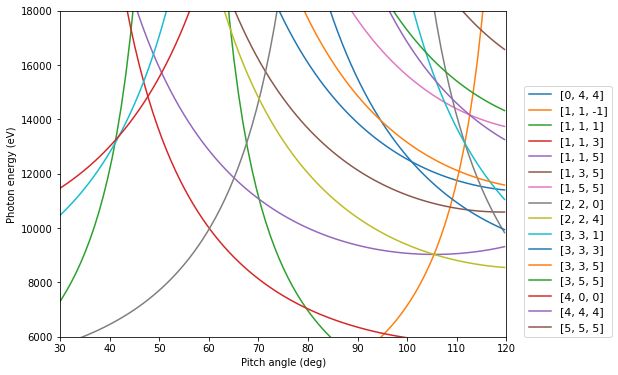

In [2]:
from functions.HXRSS_tool_plotter_limit import Bragg_plotter_limit  # Crystal model 
import matplotlib.pyplot as plt

# Model parameters, these should remain unchanged unless the photon energy is above 15 keV where hmax = 6, kmax = 6, lmax = 7.
hmax = 8
kmax = 8
lmax = 8
dthp = -0.392
dthy = 1.192
dthr = -0.1675
alpha = 0.00238
roll_angle = 1.58

phen_list, p_angle_list, gid_list, linestyle_list, color_list = Bragg_plotter_limit(hmax, kmax, lmax, dthp, dthy, dthr, alpha, roll_angle, 30, 120, 100)


plt.figure(figsize=(8,6),facecolor='white')

#plt.plot(x, y)
gidlegend = ['[0, 4, 4]', '[1, 1, 1]', '[1, 1, -1]', '[1, 1, 3]', '[1, 1, 5]', '[1, 3, 5]', '[1, 5, 5]', '[2, 2, 0]', '[2, 2, 4]', '[3, 3, 1]', '[3, 3, 3]', '[3, 3, 5]', '[3, 5, 5]', '[4, 0, 0]', '[4, 4, 4]', '[5, 5, 5]']

for phen, pangle, gid in zip(phen_list, p_angle_list, gid_list):
    if gid in gidlegend:
        plt.plot(pangle, phen, label=gid) # I am only plotting a few reflections here but there are many more

plt.xlabel("Pitch angle (deg)")
plt.ylabel("Photon energy (eV)")
plt.rcParams.update({'font.size': 11})
plt.ylim(6000, 18000) # This is the range of energies we are interested in
plt.xlim(30, 120)
plt.legend(loc=(1.04,0))
#plt.title("Crystal Reflection Model")
plt.show()

### Spectrometer images

<p> A spectrometer at the end of the output undulator is able to measure the energy at different crystal pitch angles. This results in images as shown in figure 1 below, which are saved as npz files. The lines are the reflections similar to those shown in the model above. The issue with these image is that the y-axis (photon energy) is not always correct, as a random vertical offset is present everytime we use the instrument. We would like to compare these image with the model as shown in the second image below and find this energy difference.

<ipython-input-3-b00170a2f5ce>:18: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(doocs_scale, phen_scale, orig_image, cmap='viridis', shading='auto')


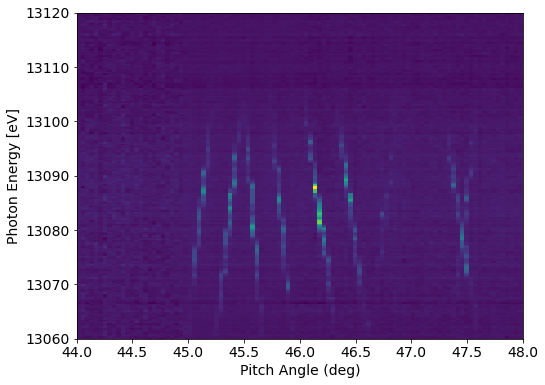

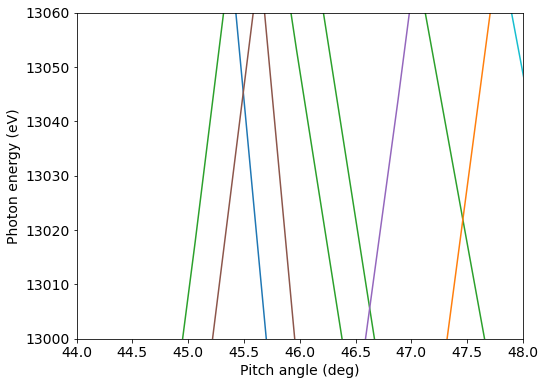

In [3]:
import numpy as np

# Load the spectrometer image
filepath = r'sampledata.nosync/20210925-22_04_34_cor2d.npz' 
tt = np.load(filepath)
corr2d = tt['corr2d']
orig_image = tt['corr2d'].T
spec_hist = tt['spec_hist']
doocs_scale = tt['doocs_scale']
phen_scale = tt['phen_scale']
doocs_label = tt['doocs_channel']


# Plot the spectrometer image
plt.figure(figsize=(8,6),facecolor='white')
plt.rcParams.update({'font.size': 14})

plt.pcolormesh(doocs_scale, phen_scale, orig_image, cmap='viridis', shading='auto')

plt.xlabel('Pitch Angle (deg)')
plt.ylabel(r'Photon Energy [eV]')
plt.ylim(13060, 13120) # This is the range of energies we are interested in
plt.xlim(44, 48)
plt.show()

# Plot the model
plt.figure(figsize=(8,6),facecolor='white')
for phen, pangle, gid in zip(phen_list, p_angle_list, gid_list):
    plt.plot(pangle, phen, label=gid) # I am only plotting a few reflections here but there are many more
plt.xlabel("Pitch angle (deg)")
plt.ylabel("Photon energy (eV)")
plt.ylim(13000, 13060)
plt.xlim(44, 48)
plt.show()

### Hough Transform

<p> The roll angle is obtained from the corresponding status text file or from the pickle file database where this file is not available. The image is created from the model with the function Bragg_plotter_limit which takes the following inputs: hmax, kmax, lmax, dthp, dthy, dthr, alpha, roll_angle, minimum pitch value, max pitch value, number of points. The outputs are the photon energy values, pitch angle values, reflection id, linestyle and color.</p>

In [21]:
from functions.HXRSS_tool_plotter_limit import Bragg_plotter_limit  # Crystal model 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os, sys
import re
import time
from datetime import datetime, timezone
import pytz
import matplotlib.colors as colors
from skimage.transform import hough_line, hough_line_peaks
from skimage.filters import threshold_yen
from matplotlib import cm
from skimage import data
from skimage import io
from skimage.color import rgb2gray
from skimage.feature import match_template
from itertools import cycle
from scipy import stats, ndimage

### Input settings

In [36]:
directory = r'sampledata.nosync/'           # This is the folder with the images and corresponding status files
readfromdb = "database/op_20220607.pkl"     # This is a dataframe with past calibration values and roll angle information for images with no status file
df_db = pd.read_pickle(readfromdb)

m=0
# Model parameters, these should remain unchanged unless the photon energy is above 15 keV where hmax = 6, kmax = 6, lmax = 7.
hmax = 6
kmax = 6
lmax = 7
dthp = -0.392
dthy = 1.192
dthr = -0.1675
alpha = 0.00238
diag=1  # Switch image processing figures on (1) or off (0)

colors=['r','w','b','m','c','r','g']
w=5
s=2
t = (((w - 1)/2)-0.5)/s

In [39]:
t

0.75

### Functions

In [40]:
# this function is used to get the roll angle from the pickle database based on the nearest available date
def nearest(items, pivot):
    return min(items, key=lambda x: abs(x - pivot))

def filtering(image):
    filtered_image =  ndimage.gaussian_filter(image, sigma=s, truncate=t)
    return filtered_image

def sobel(image):
    sx = ndimage.sobel(image, axis=0, mode='constant')
    sy = ndimage.sobel(image, axis=1, mode='constant')
    sobel_image = np.hypot(sx, sy).astype(np.int)
    return sobel_image

### Iterate through images and perform line detection


Monochromator 2 image found; from database: roll angle=1.438 deg 

20201118-20_50_56_cor2d.npz


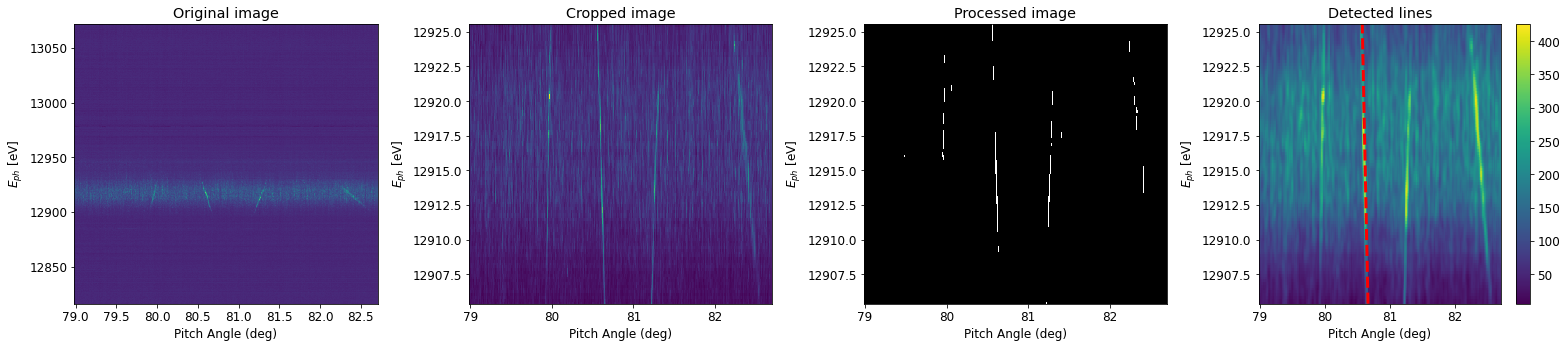

In [41]:
for filename in sorted(os.listdir(directory)):
    if filename.endswith("20_50_56_cor2d.npz"):
        filepath=os.path.join(directory, filename)
        tt = np.load(filepath)
        corr2d = tt['corr2d']
        orig_image = tt['corr2d']
        spec_hist = tt['spec_hist']
        doocs_scale = tt['doocs_scale'] 
        phen_scale = tt['phen_scale']
        doocs_label = tt['doocs_channel']
        # check if the image corresponds to a crystal pitch angle scan. MONOPA 
        if "XFEL.FEL/UNDULATOR.SASE2/MONOPA.2252.SA2/ANGLE" in doocs_label or "XFEL.FEL/UNDULATOR.SASE2/MONOPA.2307.SA2/ANGLE" in doocs_label:
            date_raw=filename[ 0 : 17 ]
            date_time_obj = datetime.strptime(date_raw, '%Y%m%d-%H_%M_%S') #strip date from image filename
            m=m+1
            # Search for corresponding roll angle from the status file or the database pickle file.
            if "XFEL.FEL/UNDULATOR.SASE2/MONOPA.2252.SA2/ANGLE" in doocs_label: 
                mono_no_pitch = 1
                try:
                    filedata = np.loadtxt(
                        filepath+'_status.txt', dtype='str', delimiter=',', skiprows=1)
                    ra_pos = np.where(
                        filedata == 'XFEL.FEL/UNDULATOR.SASE2/MONORA.2252.SA2/ANGLE')
                    ra_row = ra_pos[0][0]
                    roll_angle = float(filedata[ra_row][1])
                    print('Monochromator 1 image found; \nMachine status file found: roll angle=' + str(np.round(roll_angle, 4)) + ' deg \n')
                except:
                    try:
                        berlin = pytz.timezone('Europe/Berlin')
                        df_db['date_full'] = pd.to_datetime(df_db['date_full'], utc=True)
                        df_db['date_full'] = df_db['date_full'].dt.tz_convert("Europe/Paris")
                        dt = date_time_obj
                        dt = dt.replace(tzinfo=berlin)
                        roll = df_db['roll_angle'].loc[(df_db['date_full'] == nearest(df_db['date_full'], dt)) ]
                        roll_angle = float(roll.iloc[0])
                        print('Monochromator 1 image found; from database: roll angle=' + str(np.round(roll_angle, 4)) + ' deg \n')
                    except:
                        roll_angle = 1
                        print('Monochromator 1 image found; Default roll angle set (1 deg).')
            elif "XFEL.FEL/UNDULATOR.SASE2/MONOPA.2307.SA2/ANGLE" in doocs_label:
                mono_no_pitch = 2
                try:
                    filedata = np.loadtxt(
                        filepath+'_status.txt', dtype='str', delimiter=',', skiprows=1)
                    ra_pos = np.where(
                        filedata == 'XFEL.FEL/UNDULATOR.SASE2/MONORA.2307.SA2/ANGLE')
                    ra_row = ra_pos[0][0]
                    roll_angle = float(filedata[ra_row][1])
                    print('Monochromator 2 image found; \nMachine status file found: roll angle=' + str(np.round(roll_angle, 4)) + ' deg \n')
                except:
                    try:
                        berlin = pytz.timezone('Europe/Berlin')
                        df_db['date_full'] = pd.to_datetime(df_db['date_full'], utc=True)
                        df_db['date_full'] = df_db['date_full'].dt.tz_convert("Europe/Paris")
                        dt = date_time_obj
                        dt = dt.replace(tzinfo=berlin)
                        roll = df_db['roll_angle'].loc[(df_db['date_full'] == nearest(df_db['date_full'], dt)) ]
                        roll_angle = float(roll.iloc[0])
                        print('Monochromator 2 image found; from database: roll angle=' + str(np.round(roll_angle, 4)) + ' deg \n')
                    except:
                        roll_angle = 1
                        print('Monochromator 2 image found; Default roll angle set (1 deg).')

            else: 
                mono_no_pitch = 0    
                
            if len(doocs_scale) != len(corr2d):
                np_doocs=doocs_scale[:-1]
            else:
                np_doocs=doocs_scale
            np_phen=phen_scale
            # Calculate energy and pitch angle resolutions
            phen_res=np_phen[2]-np_phen[1]
            angle_res_p=np_doocs[2]-np_doocs[1]
            
            # Threshold the image so that the image can be clipped
            orig_image=orig_image.T
            corr2d[corr2d < 0] = 0  # all values below 0 threshold are set to 0
            thresh = threshold_yen(orig_image, nbins=256)
            binary = orig_image > thresh
            processed_image = binary
            
           
            
            # Filter out the pixels labelled '0' and keep the pixels labelled '1' and create a dataframe
            df = pd.DataFrame(data=processed_image.T).astype(int)  # Convert image values from BOOL to INT
            df_scale = pd.DataFrame(data=np_doocs)
            df_scale.columns = ['parameter']
            df_phen = pd.DataFrame(data=np_phen)
            df_phen.columns = ['value']
            df_phen = df_phen.T
            df = pd.concat([df, df_phen])
            df.columns = df.iloc[-1]
            df.drop(df.tail(1).index,inplace=True)
            df=df.join(df_scale, lsuffix='caller', rsuffix='other')
            df.set_index('parameter', inplace=True)
            df1 = df.stack().reset_index()
            #set column names
            df1.columns = ['Parameter','Energy','Correlation']
            df2 = df1[df1['Correlation'] != False]
            df2=df2.drop(columns=['Correlation'])
            
            # Min and max energies after clipping
            min_phen = min(df2['Energy'])
            max_phen = max(df2['Energy'])
            
            #print(min_phen, max_phen)
            # Create a mask with these two energies so that the image can be clipped
            mask = (np_phen > min_phen) & (np_phen < max_phen)
 
            # making new array based on mask
            phen_clipped = np_phen[mask]
            filt_image = filtering(orig_image[mask])
            # Classic straight-line Hough transform
            # Set a precision of 0.5 degree.
            tested_angles = np.linspace(-np.pi/2, np.pi/2, 360, endpoint=False)
            h, theta, d = hough_line(processed_image, theta=tested_angles) 
            linecolors = cycle(colors)
            print(filename)
            
            if diag==1:
                fig, axes = plt.subplots(1, 4, figsize=(22, 5))
                ax = axes.ravel()
                #fig.suptitle(filename, fontsize=14)
                plt.rcParams.update({'font.size': 12})
                plot = ax[0].pcolormesh(np_doocs, np_phen, orig_image, cmap='viridis', shading='auto')
                ax[0].set_title('Original image')
                ax[0].set_xlabel('Pitch Angle (deg)')
                ax[0].set_ylabel(r'$E_{ph}$ [eV]')
                
                plot = ax[1].pcolormesh(np_doocs, phen_clipped, orig_image[mask], cmap='viridis', shading='auto')
                ax[1].set_title('Cropped image')
                ax[1].set_xlabel('Pitch Angle (deg)')
                ax[1].set_ylabel(r'$E_{ph}$ [eV]')

                ax[2].pcolormesh(np_doocs, phen_clipped, processed_image[mask], cmap=cm.gray, shading='auto')
                ax[2].set_title('Processed image')
                ax[2].set_xlabel('Pitch Angle (deg)')
                ax[2].set_ylabel(r'$E_{ph}$ [eV]')

                ax[3].pcolormesh(np_doocs, phen_clipped, filt_image, cmap='viridis', shading='auto')
                ax[3].set_title('Detected lines') 
                ax[3].set_xlabel('Pitch Angle (deg)')
                ax[3].set_ylabel(r'$E_{ph}$ [eV]')
                plt.colorbar(plot)
                ax[1].locator_params(axis='x', nbins=5)
                ax[2].locator_params(axis='x', nbins=5)
            
            # Spectrometer line iteration
            emp_list, pitch_angle_list, dist_list = hough_line_peaks(h, theta, d, num_peaks=5, min_distance=30, min_angle=30)
            for pitch_angle, dist in zip(pitch_angle_list, dist_list):
                (x0, y0) = dist * np.array([np.cos(pitch_angle), np.sin(pitch_angle)])
                y_pix = ((dist-(((np_doocs-np_doocs[0])/angle_res_p)*np.cos(pitch_angle)))/np.sin(pitch_angle))
                y=min(np_phen)+(y_pix*phen_res)
                min_pangle=min(np_doocs)
                max_pangle=max(np_doocs)
                rho_p = dist
                
                pitch_angle_range = np.linspace(min_pangle, max_pangle, 10)
            
                y_pitch_pix = ((rho_p-(((pitch_angle_range-min_pangle) /
                               angle_res_p)*np.cos(pitch_angle)))/np.sin(pitch_angle))
                y_pitch = min(np_phen) + (y_pitch_pix*phen_res)
                
                # Calculate slope and intercept
                y_intercept = min(np_phen) + (rho_p*phen_res/np.sin(pitch_angle))+(
                    min_pangle*phen_res*np.cos(pitch_angle)/(angle_res_p*np.sin(pitch_angle)))
                slope = -(phen_res*np.cos(pitch_angle)/(angle_res_p*np.sin(pitch_angle)))
                
                # Inverse calculation of the pitch angle based on the energy range of the spectrometer data
                min_phen = min(df2['Energy'])
                max_phen = max(df2['Energy'])
                pa_1 = (min_phen-y_intercept)/slope
                pa_2 = (max_phen-y_intercept)/slope
                # Assign max or min angle status based on the polarity of the slope
                if pa_1 < pa_2:
                    if pa_1 < min_pangle:
                        pa_1 = min_pangle
                        min_phen = (pa_1*slope)+y_intercept
                    if pa_2 > max_pangle:
                        pa_2 = max_pangle
                        max_phen = (pa_2*slope)+y_intercept
                    min_line_pangle = pa_1
                    max_line_pangle = pa_2
                    
                else:
                    if pa_1 > max_pangle:
                        pa_1 = max_pangle
                        max_phen = (pa_1*slope)+y_intercept
                    if pa_2 < min_pangle:
                        pa_2 = min_pangle
                        min_phen = (pa_2*slope)+y_intercept
                        print(min_phen)
                    min_line_pangle = pa_2
                    max_line_pangle = pa_1
                    
                if min_pangle > min_line_pangle:
                    min_line_pangle=min_pangle
                if max_pangle < max_line_pangle:
                    max_line_pangle=max_pangle
                line_range = np.linspace(min_line_pangle, max_line_pangle, 10)
                phen = (slope*line_range)+y_intercept

                pa_vec = [pa_1, pa_2]
                phen_vec = [min(phen), max(phen)]
                centroid_pa = np.mean(pa_vec)
                centroid_phen = np.mean(phen_vec)
                
                # ignore lines which are horizontal or completely vertical
                if slope <= 10 and slope >= -10:
                    continue
                
                if y_intercept == np.inf:
                    continue
                
                if diag==1:
                    ax[3].plot(line_range, (slope*line_range)+y_intercept, color=next(linecolors), linestyle='dashed', linewidth=3)
                    #ax[2].set_ylim(min_phen, max_phen)
                    plt.tight_layout()
                    plt.show()
            if m==10:
                break
            

In [17]:
orig_image[mask]

array([[21.60128388, 24.375     , 16.41666667, ..., 30.9       ,
        20.48360656, 20.81428571],
       [20.80765573, 13.95833333, 19.5       , ..., 30.33333333,
        19.62677596, 19.38190476],
       [24.01414646, 21.08333333, 25.83333333, ..., 38.38333333,
        22.43251366, 22.53761905],
       ...,
       [48.20660961, 48.29166667, 50.16666667, ..., 47.16666667,
        49.60601093, 51.64666667],
       [48.26937708, 42.54166667, 50.83333333, ..., 46.96666667,
        49.63551913, 53.16666667],
       [42.86638136, 42.66666667, 45.75      , ..., 46.56666667,
        45.69289617, 47.80952381]])